# Monitoring coastal erosion along Africa's coastline

* **Products used:**  
[ls8_sr](https://explorer.digitalearth.africa/ls8_sr), [ls9_sr](https://explorer.digitalearth.africa/ls9_sr)  
[s2_l2a](https://explorer.digitalearth.africa/s2_l2a)  
[s1_rtc](https://explorer.digitalearth.africa/s1_rtc)

## Background
Over 40% of the world’s population lives within 100 km of the coastline. 
However, coastal environments are constantly changing, with erosion and coastal change presenting a major challenge to valuable coastal infrastructure and important ecological habitats. 
Up-to-date data on coastal change and erosion is essential for coastal managers to be able to identify and minimise the impacts of coastal change and erosion.  

Imagery from satellites such as the NASA/USGS Landsat, Copernicus Sentinel-1/2 program is available for free for the entire planet, making satellite imagery a powerful and cost-effective tool for monitoring coastlines and rivers at regional or national scale.

### DE Africa use case
The usefulness of optical imagery such as Landsat and Sentinel-2 in the coastal zone can be affected by the presence of clouds, sun-glint over water poor water quality (e.g. sediment) and the influence of tides. The effect of these factors can be reduced by combining individual noisy images into cleaner "summary" or composite layers, and filtering the data to focus only on images taken at certain tidal conditions (e.g. mid-tide). These clean, tidally-constrained composite images can then be used to identify and extract the precise boundary between water and land. This allows us to extract accurate shorelines that can be compared across time to reveal hotspots of erosion and coastal change. 

Radar observations are largely unaffected by cloud cover, so can take reliable measurements of areas in any weather. Radar data is readily available from the ESA/EC Copernicus program’s Sentinel-1 satellites. The two satellites provide all-weather observations, with a revisit time of 6 days. By developing a process to classify the observed pixels as either water or land, it is possible to identify the shoreline from radar data.

### Description

In this example, we use a simplified version of the [DE Africa Coastlines](https://github.com/digitalearthafrica/deafrica-coastlines.git) method to combine data from Landsat/Sentinel-1/Sentinel-2 satellite with image compositing and tide filtering techniques to accurately map shorelines across time, and identify areas that have changed significantly between 2018 and 2021. 
The worked example demonstrates how to:
1. Query the satellite data and select best available product
2. Process the selected data and generate annual composite images for each year
3. Extract shorelines and calculate rates of coastal change  

## Getting started
**To run this analysis**, run all the cells in the notebook, starting with the "Load packages" cell.

**After finishing the analysis**, return to the "Analysis parameters" cell, modify some values (e.g. choose a different location or time period to analyse) and re-run the analysis.
There are additional instructions on modifying the notebook at the end.

### Load packages
First we need to install additional tools from the [DE Africa Coastlines](https://github.com/digitalearthafrica/deafrica-coastlines.git) repository that will allow us to estimate rates of coastal change. 
> **Note:** If you run into any error messages in this analysis, try restarting the notebook by clicking `Kernel`, then `Restart Kernel and Clear All Outputs`.

In [1]:
!pip install -q git+https://github.com/digitalearthafrica/deafrica-coastlines.git@S2_test --disable-pip-version-check

In [5]:
# !pip install -q git+https://github.com/digitalearthafrica/deafrica-coastlines.git --disable-pip-version-check

In [2]:
pip install -q git+https://github.com/digitalearthafrica/deafrica-sandbox-notebooks.git@coastlines_s2s1#subdirectory=Tools

Note: you may need to restart the kernel to use updated packages.


Now we can load key Python packages and supporting functions for the analysis.

In [3]:
%matplotlib inline

# Force GeoPandas to use Shapely instead of PyGEOS
# In a future release, GeoPandas will switch to using Shapely by default.
import os
os.environ['USE_PYGEOS'] = '0'

import datacube
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.ops import nearest_points

from deafrica_tools.datahandling import load_ard, mostcommon_crs
from deafrica_tools.bandindices import calculate_indices
# from dea_tools.coastal import model_tides, tidal_tag, pixel_tides, tidal_stats
# from dea_tools.spatial import subpixel_contours

from deafrica_tools.coastal import model_tides, tidal_tag, pixel_tides, tidal_stats
from deafrica_tools.spatial import subpixel_contours
from deafrica_tools.plotting import display_map, rgb, map_shapefile
from deafrica_tools.dask import create_local_dask_cluster
from coastlines.raster import tide_cutoffs,load_tidal_subset
from coastlines.vector import points_on_line, annual_movements, calculate_regressions,temporal_masking,coastal_masking

from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance
from skimage.filters import threshold_minimum, threshold_otsu
from skimage.morphology import binary_erosion,disk
from datacube.utils.cog import write_cog

import warnings
warnings.filterwarnings("ignore")

### Set up a Dask cluster

Dask can be used to better manage memory use down and conduct the analysis in parallel. 
For an introduction to using Dask with Digital Earth Africa, see the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../Beginners_guide/08_parallel_processing_with_dask.ipynb).

To use Dask, set up the local computing cluster using the cell below.

In [4]:
client = create_local_dask_cluster(return_client=True)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/whusggliuqx@gmail.com/proxy/8787/status,
Dashboard: /user/whusggliuqx@gmail.com/proxy/8787/status,Workers: 1
Total threads: 4,Total memory: 26.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35003,Workers: 1
Dashboard: /user/whusggliuqx@gmail.com/proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 26.21 GiB
Comm: tcp://127.0.0.1:33725,Total threads: 4
Dashboard: /user/whusggliuqx@gmail.com/proxy/34547/status,Memory: 26.21 GiB
Nanny: tcp://127.0.0.1:38543,


### Connect to the datacube
Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [5]:
dc = datacube.Datacube(app="Coastal_erosion_Landsat_Sentinel")

### Analysis parameters

The following cell set important parameters for the analysis:

* `lat`: The central latitude to analyse (e.g. `14.283`).
* `lon`: The central longitude to analyse (e.g. `-16.921`).
* `buffer`: The number of square degrees to load around the central latitude and longitude. For reasonable loading times, set this as `0.1` or lower.
* `time_range`: The date range to analyse (e.g. `('2018', '2021') `)
* `time_step`: This parameter allows us to choose the length of the time periods we want to compare: e.g. shorelines for each year, or shorelines for each six months etc. 
`1Y` will generate one coastline for every year in the dataset; `6M` will produce a coastline for every six months, etc.
* `tide_range`: The minimum and maximum proportion of the tidal range to include in the analysis. 
For example, `tide_range = (0.50, 1.00)` will select all satellite images taken when the tide was greater than the median (i.e. 50th percentile) of all tide heights and less than the maximum (i.e. 100th percentile) of all tide heights. 
* `lee_filtering`: A boolean variable deciding on whether to apply spatial filtering on Sentinel-1 images.
* `filter_size`: An integer number of speckle filtering size for Sentinel-1. Note that no filtering will be applied if `lee_filtering` is set as False.  

This allows you to seperate the effect of erosion from the influence of tides by producing shorelines for specific tidal conditions (e.g. low tide, average tide, high tide shorelines etc). 

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.
The example explores coastal change in Ponto, Senegal. 

**To run the notebook for a different area**, make sure Sentinel-2 data is available for the new location, which you can check at the [DE Africa Explorer](https://explorer.digitalearth.africa/).

To ensure that the tidal modelling part of this analysis works correctly, please make sure the **centre of the study area is located over water** when setting `lat_range` and `lon_range`.


In [6]:
# Define the area of interest
lat = -12.4
lon = 43.736
# lat = -17.474
# lon = 43.924

buffer =  0.04

# Combine central lat,lon with buffer to get area of interest
lat_range = (lat - buffer, lat + buffer)
lon_range = (lon - buffer, lon + buffer)

# Set the range of dates for the analysis, time step and tide range
time_range = ('2018', '2021')
time_step = '1Y'
tide_range = (0.25, 0.75)

# whether to implement Lee filtering on Sentinel-1 images
lee_filtering=True
# Lee filtering size
filter_size=2

### View the selected location
The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [7]:
display_map(x=lon_range, y=lat_range)

## Query data and select best available product
The first step in this analysis is to query in Landsat, Sentinel-2 and Sentinel-1 data for the `lat_range`, `lon_range` and `time_range` we provided above. 
We use the `load_ard` function to query data from the satellites for the area and time specified.
For more information, see the [Using load_ard notebook](../Frequently_used_code/Using_load_ard.ipynb).
The function will also automatically mask out clouds from the dataset, allowing us to focus on pixels that contain useful data. 

### Query Landsat data

In [8]:
# Create the 'query' dictionary object, which contains the longitudes, 
# latitudes and time provided above
query = {
    'x': lon_range,
    'y': lat_range,
    'time': time_range,
    'measurements': ['red', 'green', 'blue', 'swir_1'],
    'resolution': (-20, 20),
}

# Identify the most common projection system in the input query 
output_crs = mostcommon_crs(dc=dc, product='ls8_sr', query=query)

# Load available data Landsat 8
ds_ls = load_ard(dc=dc, 
                 products=['ls8_sr', 'ls9_sr'], 
                 output_crs=output_crs,
                 align=(10, 10),
                 mask_filters=[("opening", 1), ("dilation", 2)],
                 dask_chunks={'time': 1},
                 group_by='solar_day',
                 resampling='bilinear',
                 **query)


Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls8_sr
    ls9_sr
Applying morphological filters to pq mask [('opening', 1), ('dilation', 2)]
Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Returning 86 time steps as a dask array


Once the load is complete, examine the data by printing it in the next cell.
The `Dimensions` argument revels the number of time steps in the data set, as well as the number of pixels in the `x` (longitude) and `y` (latitude) dimensions.

In [9]:
print(ds_ls)

<xarray.Dataset>
Dimensions:      (time: 86, y: 446, x: 438)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-03T07:09:02.121436 ... 2021-12...
  * y            (y) float64 -1.367e+06 -1.367e+06 ... -1.376e+06 -1.376e+06
  * x            (x) float64 3.582e+05 3.582e+05 ... 3.669e+05 3.67e+05
    spatial_ref  int32 32638
Data variables:
    red          (time, y, x) float32 dask.array<chunksize=(1, 446, 438), meta=np.ndarray>
    green        (time, y, x) float32 dask.array<chunksize=(1, 446, 438), meta=np.ndarray>
    blue         (time, y, x) float32 dask.array<chunksize=(1, 446, 438), meta=np.ndarray>
    swir_1       (time, y, x) float32 dask.array<chunksize=(1, 446, 438), meta=np.ndarray>
Attributes:
    crs:           epsg:32638
    grid_mapping:  spatial_ref


### Query Sentinel-2 data

In [10]:
# Load available data
ds_s2 = load_ard(dc=dc,
              products=['s2_l2a'],
              output_crs=output_crs,
              resampling='bilinear',
              align=(10, 10),
              mask_filters=[("opening", 1), ("dilation", 2)],
              dask_chunks={'time': 1},
              group_by='solar_day',
              **query)
print(ds_s2)

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Applying morphological filters to pq mask [('opening', 1), ('dilation', 2)]
Applying pixel quality/cloud mask
Returning 578 time steps as a dask array
<xarray.Dataset>
Dimensions:      (time: 578, y: 446, x: 438)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-02T07:22:04 ... 2021-12-30T07:...
  * y            (y) float64 -1.367e+06 -1.367e+06 ... -1.376e+06 -1.376e+06
  * x            (x) float64 3.582e+05 3.582e+05 ... 3.669e+05 3.67e+05
    spatial_ref  int32 32638
Data variables:
    red          (time, y, x) float32 dask.array<chunksize=(1, 446, 438), meta=np.ndarray>
    green        (time, y, x) float32 dask.array<chunksize=(1, 446, 438), meta=np.ndarray>
    blue         (time, y, x) float32 dask.array<chunksize=(1, 446, 438), meta=np.ndarray>
    swir_1       (time, y, x) float32 dask.array<chunksize=(1, 446, 438), meta=np.ndarray>
Attributes:
    crs:           epsg:32638
    grid_mapping:  

### Query Sentinel-1 data
Each of the Sentinel-1 observations was acquired from either a descending or ascending orbit, which has impacts on the local incidence angle and backscattering value. So we first load Sentinel-1 data ascending and descending orbit separately:

In [11]:
# Create the 'query' dictionary object, which contains the longitudes,
# latitudes and time provided above
query.update({'measurements': ['vh','vv','mask']})
ds_s1_ascending=load_ard(dc=dc,
              products=['s1_rtc'],
              output_crs=output_crs,
              resampling='bilinear',
              align=(10, 10),
              dask_chunks={'time': 1},
              group_by='solar_day',
              dtype='native',
              sat_orbit_state='ascending',
              **query)
ds_s1_descending=load_ard(dc=dc,
              products=['s1_rtc'],
              output_crs=output_crs,
              resampling='bilinear',
              align=(10, 10),
              dask_chunks={'time': 1},
              group_by='solar_day',
              dtype='native',
              sat_orbit_state='descending',
              **query)

Using pixel quality parameters for Sentinel 1
Finding datasets
    s1_rtc
Applying pixel quality/cloud mask
Returning 92 time steps as a dask array
Using pixel quality parameters for Sentinel 1
Finding datasets
    s1_rtc
Applying pixel quality/cloud mask
Returning 99 time steps as a dask array


To minimise the effects of inconsistent looking angle and obit direction for each individual pixel, here we filter out observations from the orbit (ascending/descending) with lower frequency over time. We then merge the two datasets together:

In [12]:
ds_s1_ascending["isAscending"] = xr.where(ds_s1_ascending['mask']!=0,1,np.nan)
ds_s1_ascending["isDescending"] = xr.where(ds_s1_ascending['mask']!=0,0,np.nan)

ds_s1_descending["isDescending"] = xr.where(ds_s1_descending['mask']!=0,1,np.nan)
ds_s1_descending["isAscending"] = xr.where(ds_s1_descending['mask']!=0,0,np.nan)

ds_s1=xr.concat([ds_s1_ascending,ds_s1_descending],dim='time')
ascending_mask=(ds_s1.isAscending.sum(dim='time')>ds_s1.isDescending.sum(dim='time'))
descending_mask=(ds_s1.isAscending.sum(dim='time')<=ds_s1.isDescending.sum(dim='time'))
ds_s1=ds_s1.where((ascending_mask&(ds_s1.isAscending==1))|(descending_mask&(ds_s1.isDescending==1)),np.nan)
# drop all-nan observations
ds_s1=ds_s1.dropna(dim='time',how='all')
print(ds_s1)

/usr/local/lib/python3.10/dist-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


<xarray.Dataset>
Dimensions:       (time: 99, y: 446, x: 438)
Coordinates:
  * time          (time) datetime64[ns] 2018-02-02T02:41:35.636685 ... 2021-1...
  * y             (y) float64 -1.367e+06 -1.367e+06 ... -1.376e+06 -1.376e+06
  * x             (x) float64 3.582e+05 3.582e+05 ... 3.669e+05 3.67e+05
    spatial_ref   int32 32638
Data variables:
    vh            (time, y, x) float32 dask.array<chunksize=(1, 446, 438), meta=np.ndarray>
    vv            (time, y, x) float32 dask.array<chunksize=(1, 446, 438), meta=np.ndarray>
    mask          (time, y, x) float64 dask.array<chunksize=(1, 446, 438), meta=np.ndarray>
    isAscending   (time, y, x) float64 dask.array<chunksize=(1, 446, 438), meta=np.ndarray>
    isDescending  (time, y, x) float64 dask.array<chunksize=(1, 446, 438), meta=np.ndarray>
Attributes:
    crs:           epsg:32638
    grid_mapping:  spatial_ref


### Plot example timestamp
To visualise Landsat and Sentinel-2 data, use the pre-loaded `rgb` utility function to plot a true colour image for a given timestamp. White areas indicate where clouds or other invalid pixels in the image have been masked:

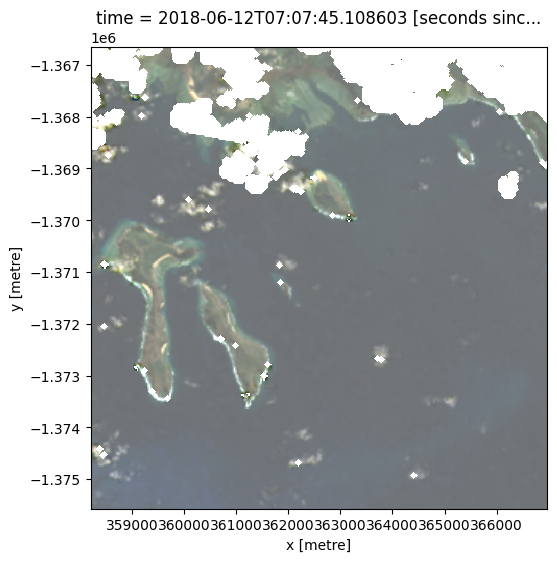

In [13]:
# Set the timesteps to visualise
timestamp = 10

# Generate RGB plots at each timestep
rgb(ds_ls, index=timestamp, percentile_stretch=[0, 0.999])

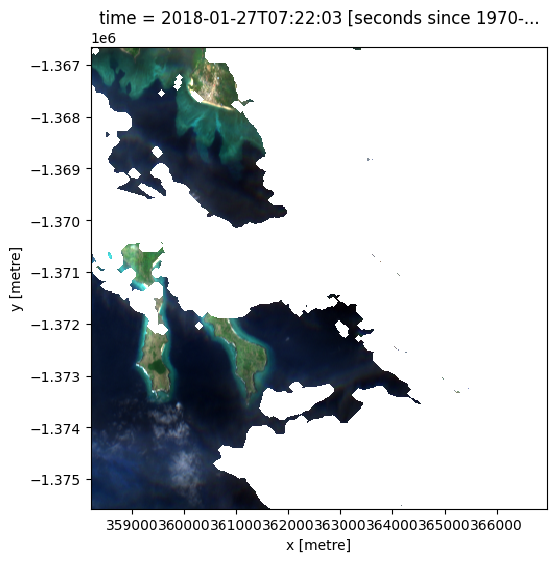

In [14]:
# Generate RGB plots at each timestamp
rgb(ds_s2, index=timestamp, percentile_stretch=[0, 0.999])

To visualise Sentinel-1 data, we can either plot a single band (e.g. vh) or three bands, e.g. vh, vv, vh/vv. Here we plot vh band as an example:

In [ ]:
ds_s1['vh'].isel(time=timestamp).to_array().plot.imshow(robust=True)

In [ ]:
# # uncomment below to plot vh, vv and vh/vv bands
# ds_s1['vh_d_vv']=ds_s1.vh/ds_s1.vv
# ds_s1[['vh','vv','vh_d_vv']].isel(time=timestamp).to_array().plot.imshow(robust=True)


Change the value for `timestamp` and re-run the cell to plot a different timestamp (timestamps are numbered from `0` to `n_time - 1` where `n_time` is the total number of timestamps; see the `time` listing under the `Dimensions` category in the dataset print-out above).


### Select best available product  
Here we define a rule-based function `choose_product` to decide which of the three products is most suitable for shoreline mapping for the given location and study period. The rules are based on the average number and frequency of obseravations within coastal zone and all timesteps:  
![Product selection rules](../Supplementary_data/Coastal_erosion/select_products.jpg)

To implement the rules we also define two some functions to calculate the number and frequency of valid observations overtime and to create a coastal zone mask so the calculation only applies to pixels within the mask: 

In [16]:
def get_mean_number_freq_valid_obs(da,coastal_mask,time_step):
    '''
    Calculate mean number of clear observations within each year/timestep in the coastal zone
    
    Parameters:
    da: xarray.DataArray
        Time series of a single satellite band/variable (e.g. MNDWI)
    coastal_mask: xarray.DataArray 
        Coastal zone mask
    time_step: string
        Pre-defined time step for temporal aggregation, e.g. '1Y'
    
    Returns:
    n_valid_obs: xarray.DataArray
        Average number of valid observations within the coastal zone and for each time step
    freq_valid: xarray.DataArray
        Average frequency of valid observations within the coastal zone and for each time step
    '''
    n_valid_obs=(~da.isnull()).resample(time=time_step).sum('time')
    n_valid_obs=n_valid_obs.where(coastal_mask).mean(dim=['x','y'])
    
    freq_valid=(~da.isnull()).resample(time=time_step).mean('time')
    freq_valid=freq_valid.where(coastal_mask).mean(dim=['x','y'])
    
    return n_valid_obs,freq_valid

In [17]:
def create_coastal_mask(ds_summaries,buffer_pixels,index='MNDWI'):
    '''
    Create a simplified coastal zone mask based on frequency of being classified as land over time
    
    Parameters:
    ds_summaries: xarray.Dataset
        Temporal composites of Landsat/Sentinel-2 imagery
    buffer_pixels: integer
        Number of pixels to buffer coastal zone
    index: string
        Spectral index for classifying land and water
    
    Returns:
    coastal_mask: xarray.DataArray 
        A single time buffered coastal zone mask, 0: non-coastal ocean, 1: coastal and 2: inland pixels
    '''
    # Set any pixels with only one observation to NaN, as these are extremely vulnerable to noise
    ds_summaries = ds_summaries.where(ds_summaries["count"] > 1)
    # apply thresholding and re-apply nodata values
    nodata = ds_summaries[index].isnull()
    thresholded_ds = ds_summaries[index] < 0
    thresholded_ds = thresholded_ds.where(~nodata)
    # Rename time attribute as year
    thresholded_ds = thresholded_ds.rename(time='year')
    # Apply temporal masking and set any pixels outside mask to 0 to represent water
    temporal_mask = temporal_masking(thresholded_ds == 1)
    thresholded_ds = thresholded_ds.where(temporal_mask)
    # use 20% valid observation layer to identify pixels that contain land for even a small period of time
    all_time_20 = (thresholded_ds.mean(dim='year') > 0.2).compute()
    # Temporary workaround to identify ocean pixels: 
    ocean_da = xr.apply_ufunc(binary_erosion, all_time_20==0, disk(60))
    # Produce buffered coastal areas: 0: non-coastal ocean, 1: coastal and 2: inland pixels
    coastal_mask = coastal_masking(ds=all_time_20, ocean_da=ocean_da, buffer=buffer_pixels)
    return coastal_mask

In [18]:
def choose_product(ds_ls,ds_s2,ds_s1,time_step,thresh_n_valid=3,thresh_freq=0.1,buffer_pixels=100):
    '''
    Rule-based guide on choosing the best availabel satellite product at given location and time step
    
    Parameters:
    ds_ls: xarray.Dataset
        Time series Landsat data
    ds_s2: xarray.Dataset
        Time series Sentinel-2 data
    ds_s1: xarray.Dataset
        Time series Sentinel-1 data
    time_step: string
        Time step for temporal composition
    thresh_n_valid: integer
        Threhold of minimum average number of valid observations within coastal zone and each time step
    thresh_freq: float
        Threshold of minimum frequency of valid observations within coastal zone and each time step
    buffer_pixels: integer
        Number of pixels to buffer coastal zone
        
    Returns:
        Xarray.Dataset of the best product
        String of the best product name: 'ls', 's2' or 's1'
    '''
    # calculate simplied coastal zone mask using Sentinel-2 data
    # calculate index
    ds_s2 = calculate_indices(ds_s2, index='MNDWI', satellite_mission='s2')
    # generate yearly composite
    ds_summaries = (ds_s2[['MNDWI']].resample(time=time_step).median('time'))
    # count valid observations per year
    ds_summaries['count']=(~ds_s2['MNDWI'].isnull()).resample(time=time_step).sum('time')
    # create coastal zone mask
    coastal_mask=create_coastal_mask(ds_summaries,buffer_pixels,'MNDWI')
    
    # calculate mean number and fraction of clear observations each year/timestep within the coastal zone
    n_valid_obs_s2,freq_valid_s2=get_mean_number_freq_valid_obs(ds_s2['MNDWI'].compute(),coastal_mask,time_step)
    n_valid_obs_ls,freq_valid_ls=get_mean_number_freq_valid_obs(ds_s2['red'].compute(),coastal_mask,time_step)
    n_valid_obs_s1,freq_valid_s1=get_mean_number_freq_valid_obs(ds_s1['vh'].compute(),coastal_mask,time_step)
    
    # apply decision rules
    if ((n_valid_obs_s2>=thresh_n_valid).all()) and ((freq_valid_s2>=thresh_freq).all()): # if Sentinel-2 meets both condition
        if ((n_valid_obs_ls>=thresh_n_valid).all()) and ((n_valid_obs_ls>=thresh_freq).all()): # if Landsat also meets both condition
            if ((n_valid_obs_ls>n_valid_obs_s2).all()) and ((n_valid_obs_ls>freq_valid_s2).all()):# if Landsat have both higher no. and fraction of clear observations
                return ds_ls,'ls'
            else: # otherwise prefer Sentinel-2
                return ds_s2,'s2'
        else:
            return ds_s2,'s2'
    elif ((n_valid_obs_ls>=thresh_n_valid).all()) and ((n_valid_obs_ls>=thresh_freq).all()): # if Sentinel-2 doesn't meet both basic conditions,but Landsat does
        return ds_ls,'ls'
    else: # if neither Sentinel-2 or Landsat meet both conditions
        return ds_s1,'s1' # choose Sentinel-1

Now we can implement the product selection function. Note **it may take a few minutes to finish**:

In [ ]:
ds_selected,product_name=choose_product(ds_ls,ds_s2,ds_s1,time_step)

Note: Above function is intended to provide some guidance on selecting the product. Alternatively you can select a product that is most fit for your purpose by setting the variable `ds_selected`. For example, uncommenting below cell will override above function and set the product to be used as Sentinel-1 data:

In [19]:
# ds_selected=ds_s1 # uncomment this line to choose Sentinel-1 product

## Process selected data and generate annual composites

### Model tide height  

For each satellite timestep, we use the `pixel_tides` function to model tide heights into a low-resolution 5 x 5 km grid (matching resolution of the [FES2014 tidal model](https://www.aviso.altimetry.fr/en/data/products/auxiliary-products/global-tide-fes/description-fes2014.html)), then reprojects modelled tides into the spatial extent of our satellite image. We add this new data as a new variable in our satellite dataset to allow each satellite pixel to be analysed and filtered/masked based on the tide height at the exact moment of satellite image acquisition. 

In [ ]:
ds_selected["tide_m"], tides_lowres = pixel_tides(ds_selected, resample=True)

### Process selected data
To extract shoreline locations, we need to be able to seperate water from land in our study area. 
To do this, for Landsat or Sentinel-2 we can calculate a water index called the `Modified Normalised Difference Water Index`, or MNDWI. 
This index uses the ratio of green and Shortwave-Infrared (SWIR) radiation to identify the presence of water [(Xu 2006)](https://doi.org/10.1080/01431160600589179). 
The formula is:

$$
\begin{aligned}
\text{MNDWI} &= \frac{(\text{Green} - \text{SWIR})}{(\text{Green} + \text{SWIR})}
\end{aligned}
$$

where `Green` is the green band and `SWIR` is the SWIR band. 

For Sentinel-1 data, as radar observations appear speckly due to random interference of coherent signals from target scatters, we may want to implement speckle filtering using Lee filter, which is one of the popular adaptive speckle filters that takes into account local homogeneity. Besides, it is often useful to convert the backscatter to decible (dB) for analysis. Backscatter in dB unit has a more symmetric noise profile and less skewed value distribution for easier statistical evaluation.  


In [ ]:
def lee_filter(da, size):
    """
    Apply lee filter of specified window size.
    Adapted from https://stackoverflow.com/questions/39785970/speckle-lee-filter-in-python

    """
    img = da.values
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    
    return img_output

In [ ]:
if product_name=='ls':
    # Calculate the water index
    ds_selected = calculate_indices(ds_selected, index='MNDWI', satellite_mission='ls')
elif product_name=='s2':
    # Calculate the water index
    ds_selected = calculate_indices(ds_selected, index='MNDWI', satellite_mission='s2')
else:
    # The lee filter above doesn't handle null values
    # We therefore set null values to 0 before applying the filter
    valid = xr.ufuncs.isfinite(ds_selected)
    ds_selected = ds_selected.where(valid, 0)

    if lee_filtering==True: # do filtering
        # Create a new entry in dataset corresponding to filtered VV and VH data
        ds_selected["filtered_vh"] = ds_selected.vh.groupby("time").apply(lee_filter, size=filter_size)
    else: # don't do filtering
        ds_selected["filtered_vh"]=ds_selected["vh"]

    # Null pixels should remain null
    ds_selected['filtered_vh'] = ds_selected.filtered_vh.where(ds_selected.filtered_vh!=0,np.nan)

    # Scale to plot data in decibels
    ds_selected['filtered_vh'] = 10 * xr.ufuncs.log10(ds_selected.filtered_vh)

### Combine observations into noise-free summary images
Individual remote sensing images can be affected by noisy data, e.g. effects of wind on the water. To produce cleaner images that can be compared more easily across time, we can create 'summary' images or composites that combine multiple images into one image to reveal the median or 'typical' appearance of the landscape for a certain time period. In this case, we use the median as the summary statistic because it prevents strong outliers from skewing the data, which would not be the case if we were to use the mean.

In the code below, we take the time series of images and combine them into single images for each `time_step`. For example, if `time_step = '2Y'`, the code will produce one new image for each two-year period in the dataset. This step can take **several minutes to load** if the study area is large.

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

In [ ]:
# Combine into summary images by `time_step`
if (product_name=='ls')or(product_name=='s2'):
    var='MNDWI'
else:
    var='filtered_vh'

ds_summaries = (ds_selected[[var]]
                 .resample(time=time_step)
                 .median('time')
                 .compute()
                )
# Rename time attribute as year
ds_summaries = ds_summaries.rename(time='year')

# Plot the output summary images
ds_summaries[var].plot(col='year',
                       cmap='RdBu',
                       col_wrap=2,
                       robust=True, size=10)
plt.show()



When it comes to interpreting the index, **High values (greater than 0, blue colours) typically represent water pixels**, while **low values (less than 0, red colours) represent land**. 

In [ ]:
# Shut down Dask client now that we have processed the data we need
client.close()

## Extract shorelines and calculate rates of coastal change 
### Extract shorelines from imagery
We now want to extract an accurate shoreline for each of the summary images above. The code below identifies the boundary between land and water by tracing a line along pixels with a given threshold value. For Landsat and Sentinel-2 images, we use a water index value of `0`. 

For Sentinel-1 images, the threshold could be determined either through simple automatic thresholding, or using a more complicated supervised classification method. In this notebook we use the `threshold_minimum` function, which computes the histogram for all backscatter values, smooths it until there are only two maxima and find the minimum in between as the threshold. 

We use the `subpixel_contours` function to identify the boundary between land and water by tracing a line along pixels with the previously identified threshold value. It returns a vector file with one line for each time step:


In [ ]:
if (product_name=='ls') or (product_name=='s2'):
    threshold=0
else:
    threshold= threshold_minimum(ds_selected[var].values[~np.isnan(ds_selected[var].values)])

contour_gdf = subpixel_contours(da=ds_summaries[var],
                                z_values=threshold,
                                dim='year',
                                crs=S1.geobox.crs,
                                output_path='annual_shorelines_{}.geojson'.format(product_name),
                                min_vertices=15)
contour_gdf=contour_gdf.set_index('year')
# Preview shoreline data
contour_gdf

### Plot resampled shorelines on an interactive map
The next cell provides an interactive map with an overlay of the shorelines identified in the previous cell. Run it to view the map (this step can take **several minutes to load** if the study area is large).

Zoom in to the map below to explore the resulting set of shorelines. 
Older shorelines are coloured in black, and more recent shorelines in yellow.
Hover over the lines to see the time period for each shoreline printed above the map.
Using this data, we can easily identify areas of coastline or rivers that have changed significantly over time, or areas that have remained stable over the entire time period. 


In [ ]:
# Plot shorelines on interactive map
contour_gdf.reset_index().explore(
    column='year',
    cmap='inferno',
    tiles=
    'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='ESRI WorldImagery')

### Calculate rates of coastal change
To identify parts of the coastline that are changing rapidly, we can use our annual shoreline data to calculate rates of coastal change in metres per year.
This can be particularly useful to reveal hotspots of coastal retreat (e.g. erosion), or hotspots of coastal growth.

To do this, we first need to create a set of evenly spaced points at every 20 metres along the most recent shoreline in our dataset. 
These points will be used to plot rates of coastal change across our study area.

In [ ]:
# Extract points at every 30 metres along the most recent shoreline
points_gdf = points_on_line(contour_gdf, index='2021', distance=20)
points_gdf.plot()

Now that we have a set of modelling points, we can measure distances from each of the points to each annual shoreline. 
This gives us a table of distances, where negative values (e.g. `-6.5`) indicate that an annual shoreline was located inland of our points, and positive values (e.g. `2.3`) indicate a shoreline was located towards the ocean. Because our points were created along our most recent 2021 shoreline, distances for 2021 will always have a distance of 0 m.

In [ ]:
# For each 30 m-spaced point, calculate the distance from
# the most recent 2021 shoreline to each other annual shoreline
# in the datasets.
points_gdf = annual_movements(points_gdf,
                              contours_gdf=contour_gdf,
                              yearly_ds=ds_summaries,
                              baseline_year=2021,
                              water_index=var)
points_gdf

Finally, we can calculate annual rates of coastal change (in metres per year) using linear regression. 
This will add several new columns to our table:

* `rate_time`: Annual rates of change (in metres per year) calculated by linearly regressing annual shoreline distances against time (excluding outliers; see `outl_time`). Negative values indicate retreat and positive values indicate growth. 
* `sig_time`: Significance (p-value) of the linear relationship between annual shoreline distances and time. Small values (e.g. p-value < 0.01 or 0.05) may indicate a coastline is undergoing consistent coastal change through time. 
* `se_time`: Standard error (in metres) of the linear relationship between annual shoreline distances and time. This can be used to generate confidence intervals around the rate of change given by rate_time (e.g. 95% confidence interval = `se_time * 1.96`)
* `outl_time`: Individual annual shoreline are noisy estimators of coastline position that can be influenced by environmental conditions (e.g. clouds, breaking waves, sea spray) or modelling issues (e.g. poor tidal modelling results or limited clear satellite observations). To obtain reliable rates of change, outlier shorelines are excluded using a robust Median Absolute Deviation outlier detection algorithm, and recorded in this column. 

In [ ]:
# Calculate rates of change using linear regression
points_gdf = calculate_regressions(points_gdf=points_gdf,
                                   contours_gdf=contour_gdf)
points_gdf

### Plot rates of coastal change on an interactive map
Now that we have calculated rates of coastal change, we can plot these on an interactive map to identify parts of the coastline that are retreating or growing over time.

When the map appears below, hover your mouse over the coloured dots that appear along the coastline for a summary of recent coastal change at those locations. 
Red dots represent locations that are retreating (e.g. erosion), and blue dots represent locations that are growing.

![coastal_change.jpg](../Supplementary_data/Coastal_erosion/coastal_change.jpg)

In [ ]:
# Add human-friendly label for plotting
points_gdf['Coastal change'] = points_gdf.apply(
    lambda x:
    f'<h4>This coastline has {"<b>retreated</b>" if x.rate_time < 0 else "<b>grown</b>"} '
    f'by</br><b>{x.rate_time:.2f} m (±{x.se_time:.1f}) per year</b> since '
    f'<b>{contour_gdf.index[0]}</b></h4>',
    axis=1)
points_gdf.loc[points_gdf.sig_time > 0.05, 'Coastal change'] = (
    f'<h4>No significant trend of retreat or growth)</h4>')

# Add annual shorelines to map
m = contour_gdf.reset_index().explore(
    column='year',
    cmap='inferno',
    tiles=
    'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    tooltip=False,
    style_kwds={'opacity': 0.5},
    attr='ESRI WorldImagery')

# Add rates of change to map
points_gdf.explore(
    m=m,
    column='rate_time',
    vmin=-5,
    vmax=5,
    tooltip='Coastal change',
    cmap='RdBu',
)

> **Important note:** This notebook may produce misleading rates of change for non-coastal waterbodies that might fluctuate naturally year-by-year.
The full [Digital Earth Africa Coastlines repository](https://github.com/digitalearthafrica/deafrica-coastlines.git) contains additional methods for producing more accurate rates of change by cleaning and filtering annual shoreline data to focus only on coastal shorelines.

### Export rates of change to file
Finally, we can export our output rates of change file so that it can be loaded in GIS software (e.g. ESRI ArcGIS or QGIS).

In [ ]:
points_gdf.to_crs('EPSG:4326').to_file(output_path.replace('annual_shorelines','rates_of_changes'))

## Next steps
When you are done, return to the "Set up analysis" cell, modify some values (e.g. `time_range`, `tide_range`, `time_step` or `lat`/`lon`) and rerun the analysis.
If you're going to change the location, you'll need to make sure Sentinel-1 data is available for the new location, which you can check at the [DE Africa Explorer](https://explorer.digitalearth.africa/products/). 

For more information about the method behind this notebook, read the scientific paper:
> Bishop-Taylor, R., Nanson, R., Sagar, S., Lymburner, L. (2021). Mapping Australia's dynamic coastline at mean sea level using three decades of Landsat imagery. Remote Sensing of Environment 267, 112734. Available: https://doi.org/10.1016/j.rse.2021.112734

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [ ]:
print(datacube.__version__)

**Last Tested:**

In [ ]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')